# Extracting output conductance parameters

In addtion to the modeling of transfer characteristic, the simplified EKV model is able to model the output conductance ($G_{DS}$) as a function of inversion coefficient ($IC$). Please find the theoretical derivation in \cite{Han2022} for your reference.

This notebook gives an example of using SEKV-E to extract the six parameters for the short-channel transfer and output characteristics. As presented in [15_minutes_to_sekve](15_minutes_to_sekve.ipynb), four parameters, $n$, $I_{spec}$, $V_{T0}$, and $\lambda_c$, model a transfer characteristic. Moreover, this tutorial presents the extraction for two addtional parameters, $\sigma_d$ and $\lambda_d$, from a set of output characteristics, which estimate the output conductance with respect to $IC$.



## Module imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 7)

import sekve
from sekve.plotting import update_rcParams

update_rcParams()

## Preparation
The experimental data of a short-channel device is provided as an example, including a transfer characteristic and a set of output characteristics at various gate voltage. Pandas module is used to read csv files and to format the data.

### Prepare the transfer characteristic data

A transfer characteristic is nothing else but the sequences of gate voltage and drain current. The cell below uses DataFrame to store the data.

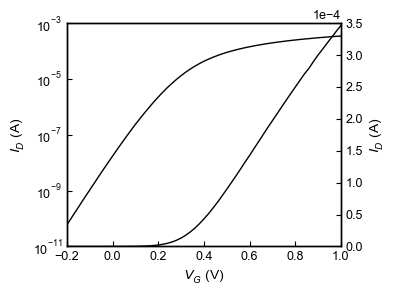

In [2]:
file = os.path.join('data/gds/IdVg_VD0.8.csv')
idvg = pd.read_csv(file, index_col=0)

ax = plt.gca()
axt = ax.twinx()
idvg.ID.plot(ax=ax)
idvg.ID.plot(ax=axt)
ax.set_yscale('log')
ax.set_xlabel('$V_G$ (V)')
ax.set_ylabel('$I_D$ (A)')
axt.set_ylabel('$I_D$ (A)');

### Prepare the output characteristics data

A set of output characteristics is required to be reformated to a `pandas.DataFrame`. The index of the DataFrame should be a sequence of drain-to-source voltage for nMOS or source-to-drain voltage for pMOS. It is not necessary to give the name to index. Each column should contain a sequence of drain-to-source current for nMOS or source-to-drain current for pMOS. It is required to give the column name that should be the gate-to-source voltage (nMOS) or source-to-gate voltage (pMOS).

The cell below presents an example of DataFrame.

In [3]:
files = os.listdir('data/gds')  # get a list of files
idvdset = {}
for file in files:
    if not file.startswith("IdVd"):  # only select the file named with IdVd...
        continue
    vg = file[7:-4]
    df = pd.read_csv(os.path.join("data", "gds", file))  # read csv file using pandas
    idvdset[vg] = df.ID  # store a sequence of drain current to a dict
vd_sweep = df.VD  # get drain voltage
df = pd.DataFrame(idvdset)  # convert a dict to dataframe
df.index = vd_sweep  # set a sequence of drain voltage to the index
df

-0.02         -0.04         -0.06  ...          0.72  \
VD                                              ...                 
0.00  1.011700e-11  4.697100e-12  2.552500e-12  ... -1.420600e-11   
0.02  7.438700e-10  4.217000e-10  2.325300e-10  ...  1.736000e-05   
0.04  1.161500e-09  6.573300e-10  3.661500e-10  ...  3.420800e-05   
...            ...           ...           ...  ...           ...   
0.76  9.101900e-09  5.316700e-09  3.019900e-09  ...  2.063600e-04   
0.78  9.435400e-09  5.527500e-09  3.134900e-09  ...  2.070800e-04   
0.80  9.911500e-09  5.766800e-09  3.275700e-09  ...  2.081200e-04   

              0.76           0.8  
VD                                
0.00 -4.000000e-11 -2.603000e-09  
0.02  1.828600e-05  1.909800e-05  
0.04  3.602600e-05  3.775200e-05  
...            ...           ...  
0.76  2.276400e-04  2.480600e-04  
0.78  2.281600e-04  2.490600e-04  
0.80  2.290400e-04  2.498200e-04  

[41 rows x 36 columns]

The output characteristics from weak to strong inversion are presented.

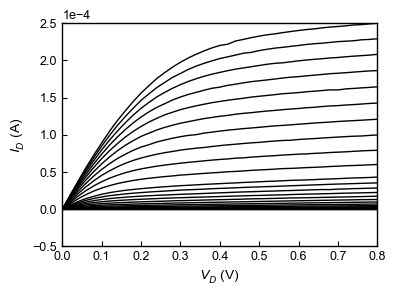

In [4]:
df.plot(legend=False, ylabel="$I_D$ (A)", xlabel="$V_D$ (V)");

## Extraction

First, we use `sekve.Extractor` to get four parameters from a transfer characteristic. This step is similar to  [15_minutes_to_sekve](15_minutes_to_sekve.ipynb). We keep the instance returned from `sekve.Extractor` for the next step. Second, the instance method `extract_sigmad_lambdad` is used to extract $\sigma_d$ and $\lambda_d$ from the structured DataFrame.

### Transfer characteristics

In [5]:
res = sekve.Extractor(vg=idvg.index.values,
                      i=idvg.ID.values,
                      vd=0.8,  # Vds value is required for extracting the output conductance
                      remove_mobility_reduction=True,
                      vth_tol=0.02,
                     )
res.run_extraction()  # Execute the extraction

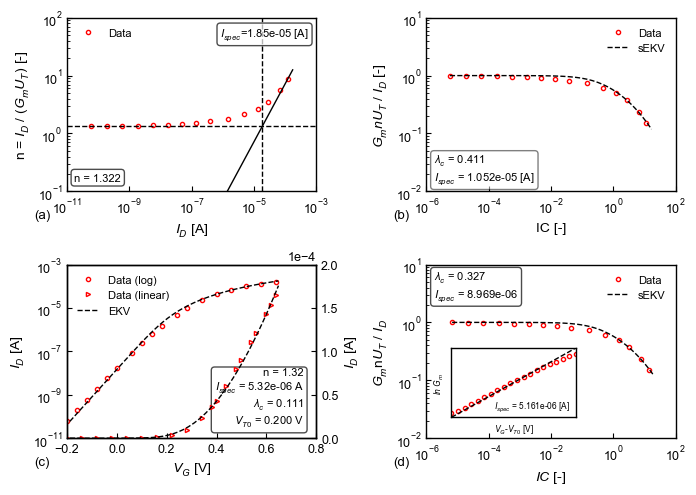

In [6]:
_ = res.progress_fig  # the figure showing each step during the extraction. 

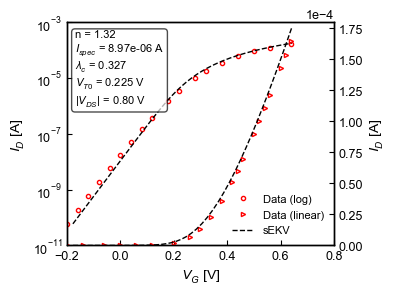

In [7]:
_ = res.final_fig  # the final result

### Output characteristics

Here, the `df` (DataFrame) structured in Sec. [3.2](#Prepare-the-output-characteristics-data) is inputted to the instance method `extract_sigmad_lambdad`. 


In [8]:
res.extract_sigmad_lambdad(df)  # Extract sigmad and lambdad

The extraction result is shown in the figure below. On the left figure, the $\sigma_d$ is extracted from the weak inversion, where $IC < 0.1$. On the right plot, the $\lambda_d$ is optimized from the $g_{DS}$ normalized to unity versus $IC$. Theoretically, $\lambda_d$ is equal to $\lambda_c$. Since we extract $\lambda_d$ from a set of output characteristics, we denote $\lambda_d$ to distinguish from $\lambda_c$, whihc is extracted from a transfer characteristic. Nevertheless, the values of $\lambda_d$ and $\lambda_c$ are close.

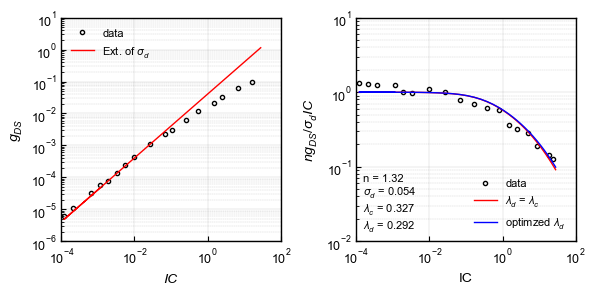

In [9]:
_ = res.output_fig

You can call the entire sEKV parameters by:

In [10]:
res.ekv_6params

{'n': 1.3224714555224633,
 'ispec': 8.968684519260403e-06,
 'lambdac': 0.3272168712745781,
 'vt0': 0.224770738872534,
 'lambdad': 0.2920048146619771,
 'sigmad': 0.05371426497372878}

Also to pandas:

In [11]:
res.ekv_6params_to_pandas(index=['short nMOS'])

n     ispec   lambdac       vt0   lambdad    sigmad
short nMOS  1.322471  0.000009  0.327217  0.224771  0.292005  0.053714

Finally, the first order approximated output conductance is compared to the output characteristic. The normalized output conductance $g_{DS}$ can be modeled through `sekve.Model.model_gDS`. Please note that the output conductance $G_{DS} = g_{DS}G_{spec}$ with $G_{spec}=I_{spec}/U_T$ (thermal voltage $U_T$). In the figure below, the red dashed lines are the approximated lines with slope of $G_{DS}$, which have the nice agreement with saturated drain current.

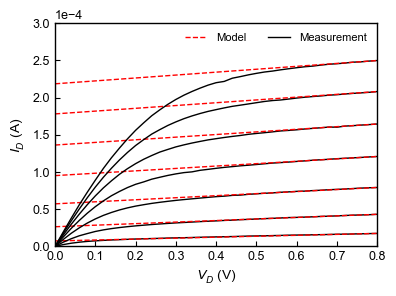

In [12]:
vg_ls = np.arange(0.32, 0.81, 0.08).round(2)
ax = plt.gca()
for vg in vg_ls:
    idvd = df[str(vg)]
    ax.plot(idvd.index, idvd.values)
    
    _id = idvd.loc[0.8]  # get drain current at VD = 0.8 V
    gDS = sekve.Model.model_gDS(_id, ispec=res.Ispec, lambdad=res.lambdad,
                                sigmad=res.sigmad, n=res.n)  # get normalized output conductance
    GDS = gDS * res.Gspec  # get output conductance
    
    ln = lambda vd: GDS*(vd-0.8) + _id
    ax.plot(idvd.index, ln(idvd.index), color='r', ls="--")

ax.set_xlabel("$V_D$ (V)")
ax.set_ylabel("$I_D$ (A)")
ax.set_ylim(0, 3e-4)
ax.plot([], [], 'r--', label='Model')
ax.plot([], [], 'k-', label='Measurement')
ax.legend(loc=0, ncol=2);

## References

[<a id="cit-Han2022" href="#call-Han2022">1</a>] Han Hung-Chi, D’Amico Antonio and Enz Christian, ``_SEKV-E: Parameter Extractor of Simplified EKV I-V Model for Low-Power Analog Circuits_'', IEEE Open Journal of Circuits and Systems, vol. 3, number , pp. 162-167,  2022.

